In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# (x_train, y_train) = (x_train[:100], y_train[:100])
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

### model

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,LeakyReLU,\
                                    Flatten,Dense,Reshape,Conv2DTranspose

from tensorflow.keras.optimizers import Adam


1. Downsample Using Strided Convolutions (e.g. don’t use pooling layers).
2. Upsample Using Strided Convolutions (e.g. use the transpose convolutional layer).
3. Use LeakyReLU (e.g. don’t use the standard ReLU).
4. Use Batch Normalization (e.g. standardize layer outputs after the activation).
5. Use Gaussian Weight Initialization (e.g. a mean of 0.0 and stdev of 0.02).
6. Use Adam Stochastic Gradient Descent (e.g. learning rate of 0.0002 and beta1 of 0.5).
7. Scale Images to the Range [-1,1] (e.g. use tanh in the output of the generator).

In [4]:
# define the discriminator model
discriminator = Sequential()
# downsample to 14x14
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=0.2))
# downsample to 7x7
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(alpha=0.2))
# classify
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [5]:
# define the generator model
generator = Sequential()
# foundation for 7x7 image
n_nodes = 64 * 7 * 7
generator.add(Dense(n_nodes, input_dim=100))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, 64)))
# upsample to 14x14
generator.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
generator.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)       

In [6]:
# make weights in the discriminator not trainable
discriminator.trainable = False
# connect them
gan_model = Sequential()
# add generator
gan_model.add(generator)
# add the discriminator
gan_model.add(discriminator)
# compile gan_model
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         404225    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 41217     
Total params: 445,442
Trainable params: 397,697
Non-trainable params: 47,745
_________________________________________________________________


In [10]:
def select_real_samples(dataset, n_batch):
    number_of_rows = dataset.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_batch, replace=False)
    random_rows = dataset[random_indices, :]
    random_rows = np.expand_dims(random_rows,axis=3)
    return random_rows, np.ones(n_batch)
# n_batch = 1
# select_real_samples(x_train, n_batch)[0].shape,select_real_samples(x_train, n_batch)[1].shape

In [11]:
def generate_latent_points(latent_dim, n_batch):
    # generate points in the latent space
	x_input = np.random.randn(latent_dim * n_batch)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_batch, latent_dim)
	return x_input

# generate_latent_points(latent_dim, n_batch).shape

In [12]:
def generate_fake_samples(generator, latent_dim, n_batch):
    x_input = generate_latent_points(latent_dim, n_batch)
    x_fake = generator.predict(x_input)
    y_fake = np.zeros(n_batch)
    return x_fake, y_fake

# generate_fake_samples(generator, latent_dim, n_batch)[0].shape,generate_fake_samples(generator, latent_dim, n_batch)[1].shape

# x_fake, y_fake = generate_fake_samples(generator, latent_dim, 1)
# x_fake

In [13]:
# gan training algorithm
def train(generator,discriminator,gan_model,n_batch=16,latent_dim=100,n_epochs=10):
    latent_dim = 100
    for i in range(n_epochs):
        # get randomly selected 'real' samples
        X_real, y_real = select_real_samples(x_train, n_batch)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_batch)
        # create training set for the discriminator
        X, y = np.vstack((X_real, X_fake)), np.hstack((y_real, y_fake))
        # update discriminator model weights
        d_loss = discriminator.train_on_batch(X, y)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
        if i % 10 == 0:
            print("Epoch", i)
        
# train(generator,discriminator,gan_model,n_epochs=1)

In [140]:
def testWeightFreeze(discriminator,generator,gan_model):
    # discriminator changes
    disc_weight_before = discriminator.non_trainable_weights[0][0][0][0][0].numpy()
    gen_weight_before = generator.trainable_weights[0][0][0].numpy()
    train(generator,discriminator,gan_model)
    disc_weight_after = discriminator.non_trainable_weights[0][0][0][0][0].numpy()
    gen_weight_after = generator.trainable_weights[0][0][0].numpy()

    (disc_weight_before, disc_weight_after), (gen_weight_before,gen_weight_after)

### Predictions

In [89]:
import matplotlib.pyplot as plt

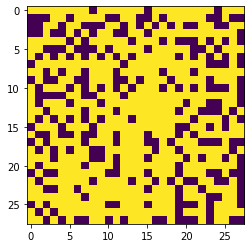

In [150]:
# prepare fake examples
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 1)
generated_sample = x_fake[0].squeeze()
plt.imshow(generated_sample)

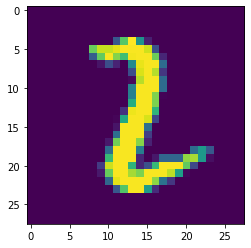

In [110]:
# prepare fake examples
x_real, y_real = select_real_samples(x_train, 1)
real_sample = x_real[0].squeeze()
plt.imshow(real_sample)